# Neural Network 실습 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
import tensorflow as tf

np.random.seed(2)

In [ ]:
# XOR training data
train_x = np.array([[0, 1], 
                    [1, 1], 
                    [0, 0], 
                    [1, 0]])
train_y = np.array([[1],[0],[0],[1]])

In [ ]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.InputLayer(input_shape=[2,]),
     tf.keras.layers.Dense(2, activation='sigmoid'),
     tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model(train_x)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.64425874],
       [0.7052611 ],
       [0.7177658 ],
       [0.7697582 ]], dtype=float32)>

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
)
model.fit(x = train_x, y = train_y,epochs=30000)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 5ms/step - loss: 0.1297 - binary_accuracy: 1.0000
Epoch 24981/30000
1/1 [==============================] - 0s 7ms/step - loss: 0.1297 - binary_accuracy: 1.0000
Epoch 24982/30000
1/1 [==============================] - 0s 6ms/step - loss: 0.1297 - binary_accuracy: 1.0000
Epoch 24983/30000
1/1 [==============================] - 0s 2ms/step - loss: 0.1297 - binary_accuracy: 1.0000
Epoch 24984/30000
1/1 [==============================] - 0s 4ms/step - loss: 0.1297 - binary_accuracy: 1.0000
Epoch 24985/30000
1/1 [==============================] - 0s 3ms/step - loss: 0.1297 - binary_accuracy: 1.0000
Epoch 24986/30000
1/1 [==============================] - 0s 3ms/step - loss: 0.1297 - binary_accuracy: 1.0000
Epoch 24987/30000
1/1 [==============================] - 0s 4ms/step - loss: 0.1297 - binary_accuracy: 1.0000
Epoch 24988/30000
1/1 [==============================] - 0s 4ms/step - loss: 0.1296 - binary_accuracy:

In [ ]:
model(train_x)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.91047734],
       [0.07879993],
       [0.09517813],
       [0.94270825]], dtype=float32)>

In [ ]:
model.variables

[<tf.Variable 'dense_6/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-4.4124603,  5.46162  ],
        [ 4.0358806, -5.5632854]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(2,) dtype=float32, numpy=array([-2.1919637, -3.2850223], dtype=float32)>,
 <tf.Variable 'dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[6.3022156],
        [6.5858636]], dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(1,) dtype=float32, numpy=array([-3.1228735], dtype=float32)>]

# Linear Regression with Neural Network

Auto MPG 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다.

In [ ]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

`pandas` 를 사용하여 데이터를 읽는다.

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
                
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


데이터 누락 (`NaN`) 값 확인

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset = dataset.dropna()

In [ ]:
# 수치형이 아닌 범주형 데이터는 제거
origin = dataset.pop('Origin')

In [ ]:
# 학습 데이터와 테스트 데이터를 분리
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

feature 통계 정보 확인

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


Feature와 label 분리

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

정규화 (z-score)

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## 모델 구성 및 생성

MAE (Mean Absolute Error)
$$
\mathrm{MAE}=\frac{1}{n} \sum_{i=1}^{n}\left|\hat{Y}_{i}-Y_{i}\right|
$$
MSE (Mean Square Error)
$$
\mathrm{MSE}=\frac{1}{n} \sum_{i=1}^{n}\left(\hat{Y}_{i}-Y_{i}\right)^{2}
$$

![images](https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png)

In [ ]:
def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.SGD(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

모델 생성

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


모델이 잘 동작하는 지 확인
(훈련 세트에서 `10` 개의 샘플을 하나의 배치로 만들어 `model.predict` 메서드를 호출)

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1271353 ],
       [-0.05629654],
       [ 0.4318631 ],
       [-0.39689544],
       [-0.2004166 ],
       [ 0.03818201],
       [-0.19227329],
       [ 0.2711233 ],
       [ 0.03463656],
       [ 0.10940136]], dtype=float32)

In [ ]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Epoch 1/1000
8/8 [==============================] - 1s 60ms/step - loss: 603.1712 - mae: 23.2648 - mse: 603.1712 - val_loss: 542.6071 - val_mae: 21.8424 - val_mse: 542.6071
Epoch 2/1000
8/8 [==============================] - 0s 24ms/step - loss: 483.2917 - mae: 20.5469 - mse: 483.2917 - val_loss: 358.7891 - val_mae: 17.2888 - val_mse: 358.7891
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 268.3375 - mae: 14.6837 - mse: 268.3375 - val_loss: 50.9155 - val_mae: 6.2273 - val_mse: 50.9155
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 42.4591 - mae: 5.1729 - mse: 42.4591 - val_loss: 32.6439 - val_mae: 4.6212 - val_mse: 32.6439
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 26.4845 - mae: 3.9897 - mse: 26.4845 - val_loss: 28.7631 - val_mae: 4.2805 - val_mse: 28.7631
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 22.3610 - mae: 3.7316 - mse: 22.3610 - val_loss: 23.7707 - val_mae: 3.8822 - val_

### 모델의 훈련 과정을 시각화

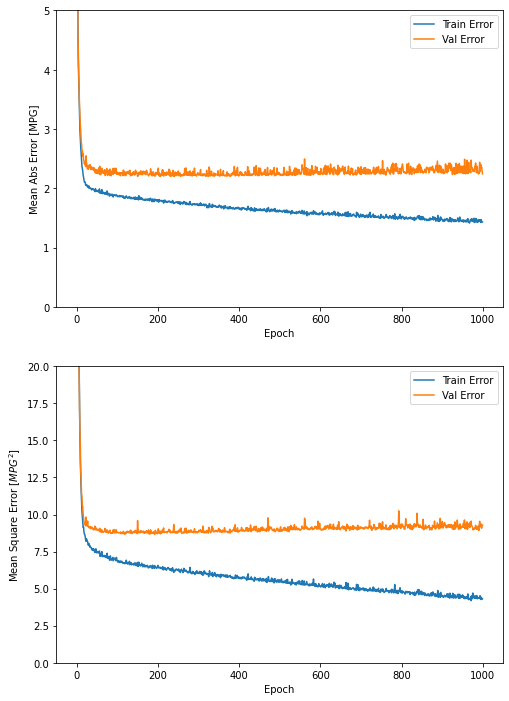

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

## Overfitting 발생 !
이 그래프를 보면 수 백번 epochs를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다. `model.fit` 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보겠습니다. 에포크마다 훈련 상태를 점검하기 위해 `EarlyStopping` 콜백(callback) 함수를 사용하겠습니다. 지정된 epochs 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

Epoch 1/1000
8/8 [==============================] - 1s 49ms/step - loss: 593.9633 - mae: 23.0897 - mse: 593.9633 - val_loss: 510.3894 - val_mae: 21.4234 - val_mse: 510.3894
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 454.8957 - mae: 20.2003 - mse: 454.8957 - val_loss: 201.0601 - val_mae: 13.2190 - val_mse: 201.0601
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 137.6626 - mae: 10.5608 - mse: 137.6626 - val_loss: 59.5754 - val_mae: 6.0982 - val_mse: 59.5754
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 51.0511 - mae: 5.8447 - mse: 51.0511 - val_loss: 44.7717 - val_mae: 5.3153 - val_mse: 44.7717
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 32.4721 - mae: 4.5786 - mse: 32.4721 - val_loss: 38.5469 - val_mae: 4.9682 - val_mse: 38.5469
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 30.4319 - mae: 4.4472 - mse: 30.4319 - val_loss: 30.3973 - val_mae: 4.4351 - val_m

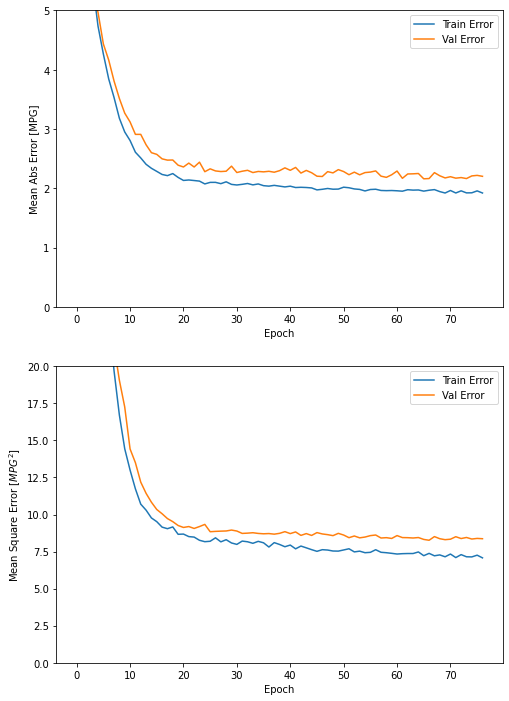

In [ ]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 epochs 횟수
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop])

plot_history(history)

모델을 훈련할 때 사용하지 않았던 테스트 세트에서 모델의 성능을 확인

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.8197 - mae: 2.0505 - mse: 6.8197
테스트 세트의 평균 절대 오차:  2.05 MPG


테스트 세트에 있는 샘플을 사용해 MPG 값을 예측

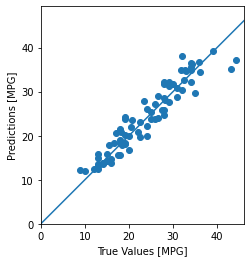

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
